In [2]:
import numpy as np
import xarray as xr
import os.path as op
import scipy.interpolate as intp
from xmitgcm import open_mdsdataset
import matplotlib.gridspec as gridspec
from matplotlib.colors import from_levels_and_colors as flc
from matplotlib import pyplot as plt
%matplotlib inline

In [3]:
res = 1e1 #km

# set output_directory to save input files. 
output_dir = '/rigel/ocp/users/tu2140/chkp63n/MITgcm/Southern-Ocean/channel_flat/input/'

# set format of binary files 
tp= '>f8'

In [4]:
# function that makes xy grid
def make_grid_xy(nx,ny, lengthx=1.0e6, lengthy=2.0e6):
    lx, ly = lengthx, lengthy
    # nx, ny = n, n
    dx, dy = lx/nx, ly/ny

    # create mesh-grids for cell centers
    xc, yc = np.meshgrid(
                dx * np.arange(nx) + dx/2,
                dy * np.arange(ny) + dy/2)
    
    return xc, yc

In [5]:
# domain width and length (currently using a square)
Ly = 2.0e6
Lx = 1.0e6

# number of center grid points (how many dx fit in the domain)
nx = int(Lx/res/1000)
ny = int(Ly/res/1000)

# generate the x,y grid
xc, yc = make_grid_xy(nx,ny, Lx,Ly)

In [6]:
ddir = '/rigel/ocp/users/tu2140/chkp63n/MITgcm/Southern-Ocean/channel_flat/input/'

# Topographic shape
Large scale shape of topography - flat bottom with gaussian bump

$$ bathy = -H + h_b = -H + h_0 e^{-x^2/\sigma^2} $$

With $H = 2985$ m, $h_0 = 927$ m and $\sigma = 75$ km.
(The particular numbers are chosen to match Ryan's previous experiments, and also work with the vertical grid)

In [5]:
H  = 2985.0
h0 = 0.
sig= 75.0e3

bathy      = -(H - h0*np.exp(-(xc - Lx/2)**2 / sig**2))
bathy[:,:] = -H
bathy[0,:] = 0.0 # create a wall to the south. By default MITgcm assumes periodic in both directions.

In [6]:
bathy.astype(tp).tofile(output_dir + 'BATHY_flat_bump_deep%03dkm.bin' % res)

# Wind conditions
We use an atmospheric jet as the wind forcing. This condition diverges slightly from Ryan's previous runs, as generate a jet that is more focussed in the center (change from $sin(y)$ to $sin^2(y)$).

$$ \tau = \tau_0 sin^2(\pi y/L_y) $$

In order to add the binomial seasonality, we change the value of $\tau_0$.

In [48]:
# tau0 = 0.2
tau0 = xr.open_dataarray('zonal-windstress-amp_SOSE.nc')
tau0

<xarray.DataArray (month: 12)>
array([ 0.142106,  0.145191,  0.157315,  0.15643 ,  0.145289,  0.135237,
        0.135194,  0.145828,  0.158918,  0.161905,  0.147637,  0.129302])
Coordinates:
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12

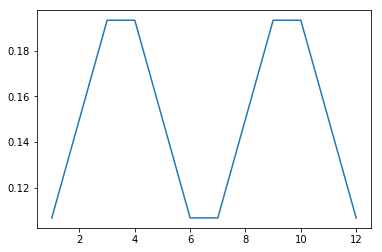

In [46]:
tau_ideal = 0.15 - 0.05*np.sin(np.pi/3*np.arange(2,14))
plt.plot(range(1,13), tau_ideal)

In [49]:
tau = np.zeros([ny,nx])

# make sure that the wind goes to zero at the north and south boundary within in the domain.
# be careful that one grid point to the south is just land. 
# the way the wind is defined right now, the wavelength changes slightly between runs.
# also make sure that the wind profile looks the same in all the runs with different resolution.

dy = yc[1,1] - yc[0,1]
tau_realistic = tau0.data[:,np.newaxis,np.newaxis]*(np.sin(np.pi* (yc)/(Ly))**2) # slightly squeezed wind profile to account 
tau = tau_ideal[:,np.newaxis,np.newaxis]*(np.sin(np.pi* (yc)/(Ly))**2)
# for the presence of land cell at the southern most grid cell.

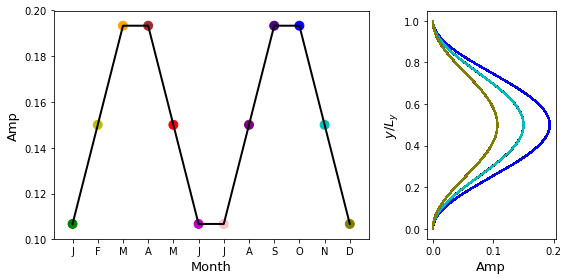

In [13]:
colors = ['g','y','orange','brown','r','m','pink','purple','indigo','b','c','olive']

fig = plt.figure(figsize=(8,4))
gs = gridspec.GridSpec(nrows=1,ncols=6)
ax1 = plt.subplot(gs[:,:4])
ax2 = plt.subplot(gs[:,4:])
ax1.plot(range(1,13),tau_ideal, 'k', lw=2)
# ax1.plot(range(1,13),tau0, 'k--', lw=2)
ax1.scatter(range(1,13),tau_ideal,color=colors,s=80)
ax1.set_xticks(range(1,13))
ax1.set_xticklabels(['J','F','M','A','M','J','J','A','S','O','N','D'])
ax1.set_xlabel('Month', fontsize=13)
ax1.set_ylabel('Amp', fontsize=13)
for i in range(12):
    ax2.plot(tau[i,:,0],yc/Ly,c=colors[i])
ax2.set_xlabel('Amp', fontsize=13)
ax2.set_ylabel(r'$y/L_y$', fontsize=13)
plt.tight_layout()
plt.savefig('SurfaceTau-sin2_seasonality_sinusoid.pdf')

In [56]:
tau.shape

(12, 200, 100)

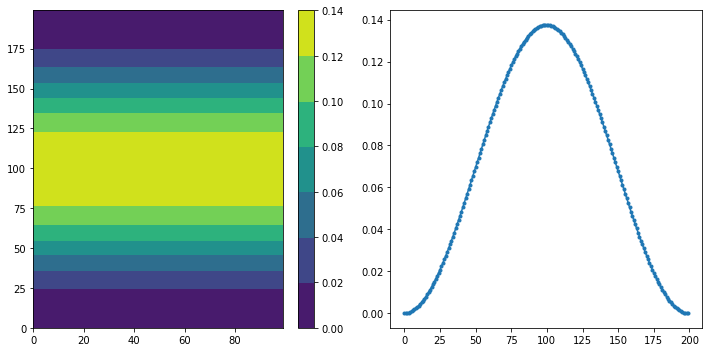

In [57]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.contourf(tau[0])
plt.colorbar()

plt.subplot(1,2,2)
plt.plot(tau[0,:,0],'.-')
plt.tight_layout()

In [19]:
print(tau.shape)
tau.astype(tp).tofile((output_dir + 'TAU-sin2_seasonal_ideal_%03dkm.bin'%res))
tau_realistic.astype(tp).tofile((output_dir + 'TAU-sin2_seasonal_%03dkm.bin'%res))

(12, 200, 100)


# Surface buoyancy conditions
Restore the surface to a linear buoyancy profile (temperature as there is no salt in the simulation)

$$ T(y) = T_0 (y/L_y) $$

where $T_0$ is also changed to incorporate seasonality.

[ 10.8660254  11.         10.8660254  10.5        10.          9.5
   9.1339746   9.          9.1339746   9.5        10.         10.5      ] [  8.66025404e-01   1.00000000e+00   8.66025404e-01   5.00000000e-01
   6.12323400e-17  -5.00000000e-01  -8.66025404e-01  -1.00000000e+00
  -8.66025404e-01  -5.00000000e-01  -1.83697020e-16   5.00000000e-01]


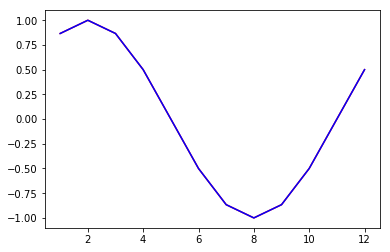

In [26]:
# Tmin, Tmax = 0., 8.0
# Tvar = xr.open_dataarray('theta-surface-seasonality_SOSE.nc')
# ds = xr.open_dataset(op.join(ddir, 'BSOSE-SST_40-65S_100-140E_rot-8.nc'))
# sst = ds.SST
sst_n = np.roll(1*np.cos(np.arange(0.,2*np.pi,2*np.pi/12.))+1e1,1)
sst_s = np.roll(1*np.cos(np.arange(0.,2*np.pi,2*np.pi/12.))+0.,1)
sst_m = np.roll(1*np.cos(np.arange(0.,2*np.pi,2*np.pi/12.))+5,1)
# sst_tf = np.roll(0.05*np.cos(np.arange(0.,2*np.pi,2*np.pi/12.))+9.45,1)
# slopes = np.roll(1*np.cos(np.arange(0.,2*np.pi,2*np.pi/12.))+7,7)/2e2
# slopen = np.roll(3.5*np.cos(np.arange(0.,2*np.pi,2*np.pi/12.))+6.5,1)/2e2
print(sst_n,sst_s)

plt.plot(range(1,13),sst_n-10,'r')
plt.plot(range(1,13),sst_s,'b')
# plt.plot(np.cos(np.arange(0.,2*np.pi,2*np.pi/12.))+9, 'k-.')
# plt.plot(np.cos(np.arange(0.,2*np.pi,2*np.pi/12.))+9, 'k--')
# sst[:,20:120].plot()

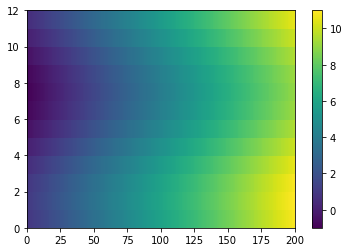

In [55]:
sst = sst_n[:,np.newaxis] + np.linspace(-10.,0.,num=ny)[np.newaxis,:]
# sst = np.zeros((12,ny))
# mid = int(.5*ny) 
# thfr = int(.75*ny)
# for i in range(12):
#     sst[i,:mid+1] = np.linspace(sst_s[i],sst_m[i],mid+1)
#     sst[i,mid:thfr+1] = np.linspace(sst_m[i],8.5,thfr-mid+1)
#     sst[i,thfr:] = np.linspace(8.5,sst_n[i],ny-thfr,endpoint=False)
# sst_lin = sst.copy()
# sst[:,125:166] += np.linspace(0,-1.25,num=41)
# sst[:,166:176] += np.linspace(-1.25,0,num=11)[1:]

fig, ax = plt.subplots()
cax = ax.pcolormesh(sst)
fig.colorbar(cax)

In [31]:
print(mid,thfr)

100 150


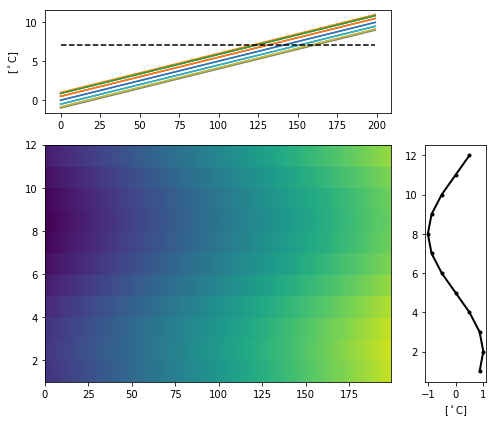

In [56]:
fig = plt.figure(figsize=(7,6))
gs = gridspec.GridSpec(nrows=3,ncols=5)
ax1 = plt.subplot(gs[0,:4])
ax2 = plt.subplot(gs[1:,:4])
ax3 = plt.subplot(gs[1:,4:])
for i in range(12):
    ax1.plot(sst[i])
ax1.plot(range(200),7.05*np.ones(200), 'k--')
# ax1.plot(range(200),8.*np.ones(200), 'k--')
ax1.set_ylabel(r'[$^\circ$C]')
ax2.pcolormesh(range(200),range(1,13),sst[:], vmax=1.2e1, rasterized=True)
ax3.plot(sst[:,0], range(1,13), 'k.-', lw=2)
ax3.set_xlabel(r'[$^\circ$C]')
# ax2.colorbar()
plt.tight_layout()

In [35]:
print(np.diff(sst[1]))
print(sst[1])
# print(sst[:,-1]-sst[:,0])
# print(sst[:,-1])
# print(sst_n)

[ 0.05  0.05  0.05  0.05  0.05  0.05  0.05  0.05  0.05  0.05  0.05  0.05
  0.05  0.05  0.05  0.05  0.05  0.05  0.05  0.05  0.05  0.05  0.05  0.05
  0.05  0.05  0.05  0.05  0.05  0.05  0.05  0.05  0.05  0.05  0.05  0.05
  0.05  0.05  0.05  0.05  0.05  0.05  0.05  0.05  0.05  0.05  0.05  0.05
  0.05  0.05  0.05  0.05  0.05  0.05  0.05  0.05  0.05  0.05  0.05  0.05
  0.05  0.05  0.05  0.05  0.05  0.05  0.05  0.05  0.05  0.05  0.05  0.05
  0.05  0.05  0.05  0.05  0.05  0.05  0.05  0.05  0.05  0.05  0.05  0.05
  0.05  0.05  0.05  0.05  0.05  0.05  0.05  0.05  0.05  0.05  0.05  0.05
  0.05  0.05  0.05  0.05  0.05  0.05  0.05  0.05  0.05  0.05  0.05  0.05
  0.05  0.05  0.05  0.05  0.05  0.05  0.05  0.05  0.05  0.05  0.05  0.05
  0.05  0.05  0.05  0.05  0.05  0.05  0.05  0.05  0.05  0.05  0.05  0.05
  0.05  0.05  0.05  0.05  0.05  0.05  0.05  0.05  0.05  0.05  0.05  0.05
  0.05  0.05  0.05  0.05  0.05  0.05  0.05  0.05  0.05  0.05  0.05  0.05
  0.05  0.05  0.05  0.05  0.05  0.05  0.05  0.05  0

NameError: name 'tau_ideal' is not defined

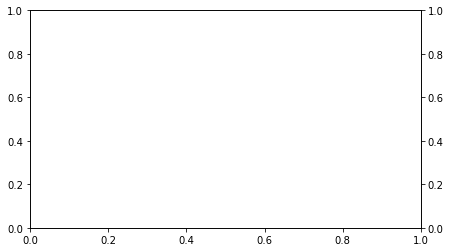

In [111]:
fig, ax = plt.subplots(figsize=(7,4))
ax2 = ax.twinx()
ax.plot(range(1,13),tau_ideal, 'b', lw=2)
ax.scatter(range(1,13),tau_ideal,color='b',s=40)
ax2.plot(range(1,13),sst[:,0], 'r', lw=2)
ax2.scatter(range(1,13),sst[:,0],color='r',s=40)
ax.set_xticks(range(1,13))
ax.set_xticklabels(['J','F','M','A','M','J','J','A','S','O','N','D'])
ax.set_xlabel('Month', fontsize=13)
ax.set_ylabel('Wind stress', fontsize=13)
ax2.set_ylabel('Southern SST relaxation', fontsize=13)
ax.tick_params('y', colors='b')
ax2.tick_params('y', colors='r')
plt.tight_layout()
plt.savefig('Tau_SouthSSTrelax.pdf')

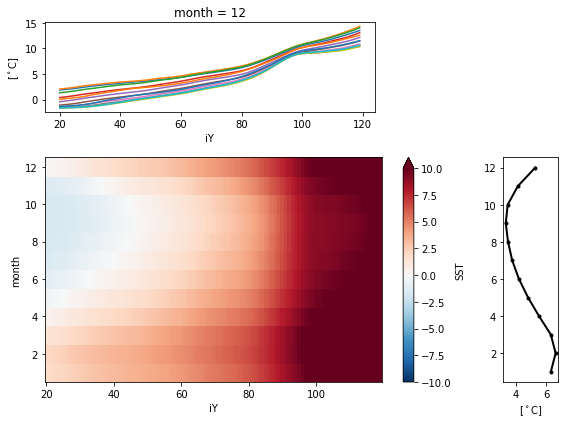

In [7]:
fig = plt.figure(figsize=(8,6))
gs = gridspec.GridSpec(nrows=3,ncols=6)
ax1 = plt.subplot(gs[0,:4])
ax2 = plt.subplot(gs[1:,:5])
ax3 = plt.subplot(gs[1:,5:])
for i in range(12):
    sst[i,20:120].plot(ax=ax1)
ax1.set_ylabel(r'[$^\circ$C]')
sst[:,20:120].plot(ax=ax2, vmax=1e1, rasterized=True)
ax3.plot(sst[:,20:120].mean('iY'),sst.month, 'k.-', lw=2)
ax3.set_xlabel(r'[$^\circ$C]')
plt.tight_layout()
# plt.savefig('SurfaceTempRelax_seasonality.pdf')

In [8]:
# Tmin, Tmax = 0., 8.0
# Tsurf = (Tmax-Tmin)*yc/Ly

Tsurf = np.zeros((12,200,100))
for i in range(12):
    f = intp.interp1d(np.arange(100), sst[i,20:120].data, fill_value='extrapolate')
    Tsurf[i] = f(np.arange(0,100,.5))[:,np.newaxis] * np.ones(100)

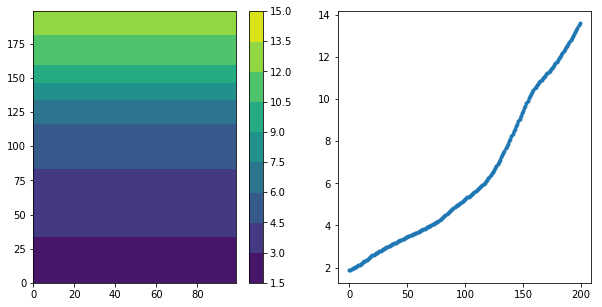

In [9]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.contourf(Tsurf[0])
plt.colorbar()

plt.subplot(1,2,2)
plt.plot(Tsurf[0,:,0],'.-')

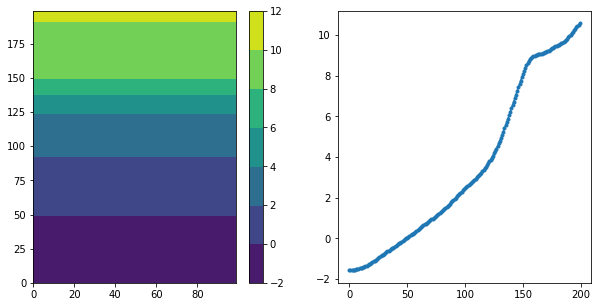

In [10]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.contourf(Tsurf[7])
plt.colorbar()

plt.subplot(1,2,2)
plt.plot(Tsurf[7,:,0],'.-')

In [36]:
print((sst[:,:,np.newaxis]*np.ones(nx)[np.newaxis,np.newaxis,:]).shape)
(sst[:,:,np.newaxis]*np.ones(nx)[np.newaxis,np.newaxis,:]).astype(tp).tofile((output_dir 
                                                                              + 'SST_change-of-slope_%03dkm.bin' 
                                                                              %res))
# (sst_lin[:,:,np.newaxis]*np.ones(nx)[np.newaxis,np.newaxis,:]).astype(tp).tofile((output_dir 
#                                                                                   + 'SST_largegrad-linear_%03dkm.bin' 
#                                                                                   %res))

(12, 200, 100)


# PAR condition

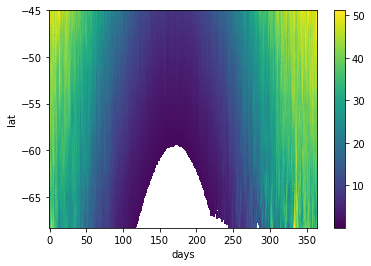

In [58]:
PARvar = xr.open_dataarray('PAR_45-65_SeaWiFS.nc')
PARvar[:,20:].plot(x='days',y='lat')

In [8]:
PARvar

<xarray.DataArray (days: 365, lat: 300)>
[109500 values with dtype=float64]
Coordinates:
  * days     (days) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
  * lat      (lat) float64 -43.38 -43.46 -43.54 -43.63 -43.71 -43.79 -43.88 ...

In [59]:
PAR_mon = np.zeros((12,300))
mon_days = {'Jan':range(31),'Feb':range(31,59),'Mar':range(59,90),'Apr':range(90,120),'May':range(120,151),
           'Jun':range(151,181),'Jul':range(181,212),'Aug':range(212,243),'Sep':range(243,273),'Oct':range(273,304),
           'Nov':range(304,334),'Dec':range(334,365)}
months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
i = 0
for month in months:
    PAR_mon[i] = np.nanmean(PARvar[mon_days[month][0]:mon_days[month][-1]], axis=0)
    i += 1

PAR_mon = xr.DataArray(PAR_mon, dims=['month','lat'],
                       coords={'month':range(1,13), 'lat':PARvar.lat.data}
                      )

/rigel/home/tu2140/miniconda3/envs/uptodate/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: Mean of empty slice
  


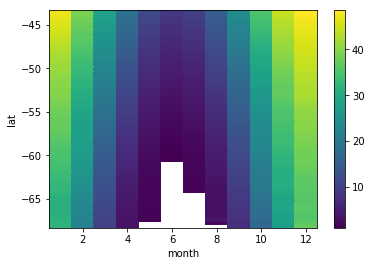

In [60]:
PAR_mon.plot(x='month',y='lat')

In [61]:
def nan_helper(y):
    """Helper to handle indices and logical indices of NaNs.

    Input:
        - y, 1d numpy array with possible NaNs
    Output:
        - nans, logical indices of NaNs
        - index, a function, with signature indices= index(logical_indices),
          to convert logical indices of NaNs to 'equivalent' indices
    Example:
        >>> # linear interpolation of NaNs
        >>> nans, x= nan_helper(y)
        >>> y[nans]= np.interp(x(nans), x(~nans), y[~nans])
    """

    return np.isnan(y), lambda z: z.nonzero()[0]

In [62]:
for i in range(12):
    nans, x = nan_helper(PAR_mon[i].data)
    PAR_mon[i,nans] = np.interp(x(nans), x(~nans), PAR_mon.data[i,~nans])

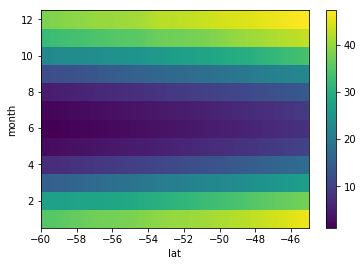

In [63]:
PAR_mon.sel(lat=slice(-45.,-60.)).plot()

<xarray.DataArray ()>
array(-9.83553729472123)


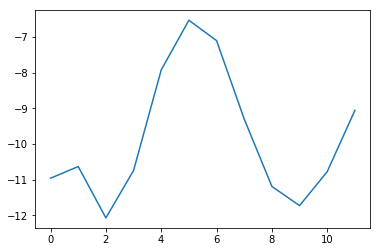

In [65]:
dPAR = PAR_mon.sel(lat=slice(-45.,-60.))[:,-1]-PAR_mon.sel(lat=slice(-45.,-60.))[:,0]
print(dPAR.mean())
plt.plot(dPAR)

In [82]:
par_north = 3e1+2e1*np.cos(np.pi/6*np.arange(1,13))
par_ideal = par_north[:,np.newaxis] + np.linspace(-10,0,num=ny)[np.newaxis,:]

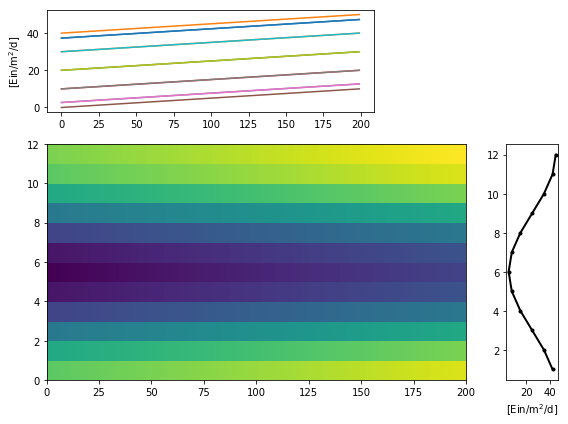

In [83]:
fig = plt.figure(figsize=(8,6))
gs = gridspec.GridSpec(nrows=3,ncols=6)
ax1 = plt.subplot(gs[0,:4])
ax2 = plt.subplot(gs[1:,:5])
ax3 = plt.subplot(gs[1:,5:])
for i in range(12):
    ax1.plot(par_ideal[i])
ax1.set_ylabel(r'[Ein/m$^2$/d]')
ax2.pcolormesh(par_ideal)
ax3.plot(par_ideal.mean(axis=-1), 
         range(1,13), 'k.-', lw=2)
ax3.set_xlabel(r'[Ein/m$^2$/d]')
plt.tight_layout()
# plt.savefig('PAR_seasonality.pdf')

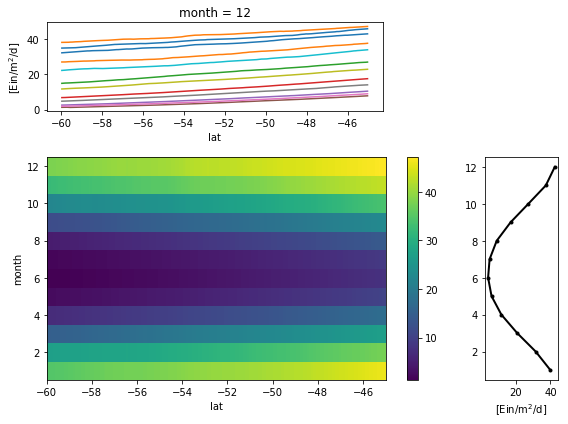

In [72]:
fig = plt.figure(figsize=(8,6))
gs = gridspec.GridSpec(nrows=3,ncols=6)
ax1 = plt.subplot(gs[0,:4])
ax2 = plt.subplot(gs[1:,:5])
ax3 = plt.subplot(gs[1:,5:])
for i in range(12):
    PAR_mon.sel(lat=slice(-45.,-60.))[i].plot(ax=ax1)
ax1.set_ylabel(r'[Ein/m$^2$/d]')
PAR_mon.sel(lat=slice(-45.,-60.)).plot(ax=ax2, rasterized=True)
ax3.plot(PAR_mon.sel(lat=slice(-45.,-60.)).mean('lat'), 
         Tvar.months, 'k.-', lw=2)
ax3.set_xlabel(r'[Ein/m$^2$/d]')
plt.tight_layout()
# plt.savefig('PAR_seasonality.pdf')

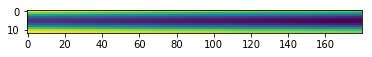

In [35]:
plt.imshow(PAR_mon.sel(lat=slice(-45.,-60.)).data)

In [32]:
PAR_mon.sel(lat=slice(-45.,-60.))

<xarray.DataArray (month: 12, lat: 180)>
array([[ 45.898347,  45.831076,  45.714652, ...,  34.999574,  34.988059,
         34.935979],
       [ 37.667248,  37.550736,  37.483492, ...,  27.049212,  27.063788,
         27.032973],
       [ 26.983407,  26.885225,  26.849725, ...,  15.0639  ,  14.984814,
         14.906311],
       ..., 
       [ 33.973304,  33.909159,  33.834854, ...,  22.394544,  22.318544,
         22.241424],
       [ 43.021811,  42.967677,  42.865669, ...,  32.375318,  32.304694,
         32.244368],
       [ 47.22691 ,  47.165099,  47.131571, ...,  38.217194,  38.206489,
         38.170315]])
Coordinates:
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
  * lat      (lat) float64 -45.04 -45.13 -45.21 -45.29 -45.38 -45.46 -45.54 ...

In [37]:
PAR = np.zeros((12,200,100))
for i in range(12):
    f = intp.interp1d(np.arange(180), np.flipud(PAR_mon.sel(lat=slice(-45.,-60.))[i].data), fill_value='extrapolate')
    PAR[i] = f(np.arange(0,180,180*5e-3))[:,np.newaxis] * np.ones(100)

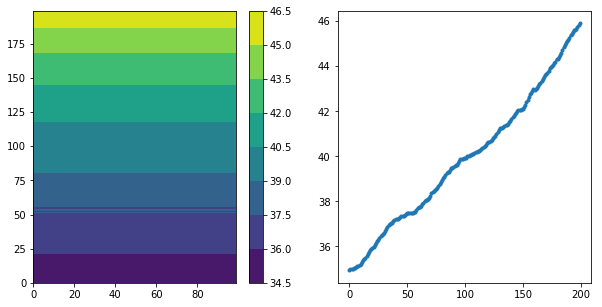

In [38]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.contourf(PAR[0])
plt.colorbar()

plt.subplot(1,2,2)
plt.plot(PAR[0,:,0],'.-')

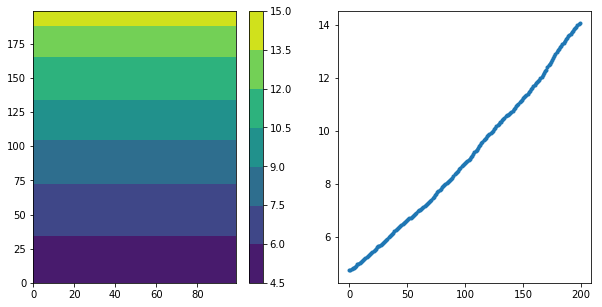

In [40]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.contourf(PAR[7])
plt.colorbar()

plt.subplot(1,2,2)
plt.plot(PAR[7,:,0],'.-')

In [84]:
print((par_ideal[:,:,np.newaxis]*np.ones(nx)[np.newaxis,np.newaxis,:]).shape)
(par_ideal[:,:,np.newaxis]*np.ones(nx)[np.newaxis,np.newaxis,:]).astype(tp).tofile(output_dir 
                                                                                   + 'PAR_linear_%03dkm.bin' %res)

(12, 200, 100)


# Interpolate the initial conditions on stratification
Currently just using the ones from the old runs by Ryan. However the exact intial condition shouldn't be significant.

In [37]:
zaxis = np.array([-5. ,   -15. ,   -25. ,   -36. ,   -49. ,   -64. ,   -81.5,
                -102. ,  -126. ,  -154. ,  -187. ,  -226. ,  -272. ,  -327. ,
                -393. ,  -471.5,  -565. ,  -667.5,  -770.5,  -873.5,  -976.5,
               -1079.5, -1182.5, -1285.5, -1388.5, -1491.5, -1594.5, -1697.5,
               -1800.5, -1903.5, -2006.5, -2109.5, -2212.5, -2315.5, -2418.5,
               -2521.5, -2624.5, -2727.5, -2830.5, -2933.5])

In [9]:
np.linspace(-3e2,-3e3,num=10)

array([ -300.,  -600.,  -900., -1200., -1500., -1800., -2100., -2400.,
       -2700., -3000.])

In [58]:
dtype = '>f8'
shape = (12,200,100)
sst = np.fromfile(op.join(ddir, 'SST_change-of-slope_010km.bin'), 
                           dtype=dtype)
sst.shape = shape
sst[:,-1,0]

array([ 10.8187049,  10.95     ,  10.8187049,  10.46     ,   9.97     ,
         9.48     ,   9.1212951,   8.99     ,   9.1212951,   9.48     ,
         9.97     ,  10.46     ])

In [59]:
# delT = 8.0 
# h = 1000. 
# Hmax = 2985.0

# # Use expression (2) from Abernathey et al 2011
# Tstar = delT*(np.exp(zaxis/h) - np.exp(-Hmax/h))/(1-  np.exp(-Hmax/h))

# #plt.plot(temp_relax_large[:,200,0] , zaxis)
# plt.plot(Tstar, zaxis) 
# # There is slight difference from the profile in the paper. 
# # so we will use the analytical expression
top = 10
temp_north = np.zeros((12,len(zaxis)))
temp_north[:,top:15] = .1/317.5*zaxis[top:15] + 8.55+.1*154/317.5
temp_north[:,15:] = 9.45/2462*zaxis[15:] + 8.45+9.55*471.5/2462
temp_north[:,0] = sst[:,-1,0]
# Nov
# temp_north[-2,:2] = temp_north[-2,0]
# a = (temp_north[-2,1]-temp_north[-2,7])/(zaxis[1]-zaxis[7])
# b = temp_north[-2,1] - a*zaxis[1]
# temp_north[-2,2:7] = a*zaxis[2:7] + b
# Nov & Dec
temp_north[-2:,:3] = temp_north[-2:,0][:,np.newaxis]
a = (temp_north[-2:,2]-temp_north[-2:,top])/(zaxis[2]-zaxis[top])
b = temp_north[-2:,2] - a*zaxis[2]
temp_north[-2:,3:top] = a[:,np.newaxis]*zaxis[3:top][np.newaxis,:] + b[:,np.newaxis]
# Jan - Mar
for i in range(3):
    if i < 2:
        temp_north[i,:3] = temp_north[i,0]
        a = (temp_north[i,2]-temp_north[i,top])/(zaxis[2]-zaxis[top])
        b = temp_north[i,2] - a*zaxis[2]
        temp_north[i,3:top] = a*zaxis[3:top] + b
    else:
        temp_north[i,:5] = temp_north[i,0]
        a = (temp_north[i,4]-temp_north[i,top])/(zaxis[4]-zaxis[top])
        b = temp_north[i,4] - a*zaxis[4]
        temp_north[i,5:top] = a*zaxis[5:top] + b
# Apr - Jun
for i in range(3,6):
    temp_north[i,:(i+3)] = temp_north[i,0]
    a = (temp_north[i,(i+2)]-temp_north[i,top])/(zaxis[i+2]-zaxis[top])
    b = temp_north[i,(i+2)] - a*zaxis[i+2]
    temp_north[i,(i+3):top] = a*zaxis[(i+3):top] + b
# Jul - Oct
for i in range(6,10):
    if i < 9: 
#         temp_north[i,:1] = temp_north[i,0]
        a = (temp_north[i,0]-temp_north[i,top])/(zaxis[0]-zaxis[top])
        b = temp_north[i,0] - a*zaxis[0]
        temp_north[i,1:top] = a*zaxis[1:top] + b
    else:
        temp_north[i,:3] = temp_north[i,0]
        a = (temp_north[i,2]-temp_north[i,top])/(zaxis[2]-zaxis[top])
        b = temp_north[i,2] - a*zaxis[2]
        temp_north[i,3:top] = a*zaxis[3:top] + b

In [60]:
print(temp_north[:,13])
print(temp_north[:,14])
print(np.diff(temp_north[0,11:]))

[ 8.49551181  8.49551181  8.49551181  8.49551181  8.49551181  8.49551181
  8.49551181  8.49551181  8.49551181  8.49551181  8.49551181  8.49551181]
[ 8.47472441  8.47472441  8.47472441  8.47472441  8.47472441  8.47472441
  8.47472441  8.47472441  8.47472441  8.47472441  8.47472441  8.47472441]
[-0.01448819 -0.01732283 -0.0207874  -0.00557331 -0.35888505 -0.39343014
 -0.39534931 -0.39534931 -0.39534931 -0.39534931 -0.39534931 -0.39534931
 -0.39534931 -0.39534931 -0.39534931 -0.39534931 -0.39534931 -0.39534931
 -0.39534931 -0.39534931 -0.39534931 -0.39534931 -0.39534931 -0.39534931
 -0.39534931 -0.39534931 -0.39534931 -0.39534931]


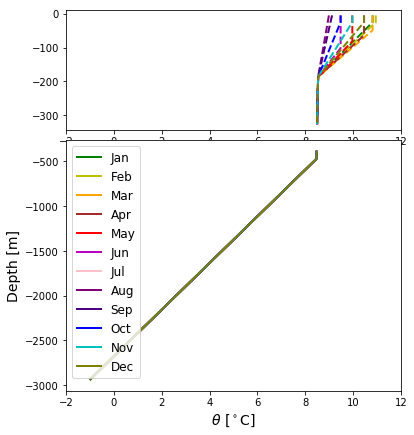

In [61]:
colors = ['g','y','orange','brown','r','m','pink','purple','indigo','b','c','olive']
month = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
npl = 14

fig = plt.figure(figsize=(6,7))
gs = gridspec.GridSpec(nrows=6,ncols=1)
ax1 = plt.subplot(gs[:2])
ax2 = plt.subplot(gs[2:])
for i in range(12):
    ax1.plot(temp_north[i,:npl], zaxis[:npl], '--',
             label=month[i], color=colors[i], lw=2)
    ax2.plot(temp_north[i,npl:], zaxis[npl:], 
            label=month[i], color=colors[i], lw=2)

ax1.set_xlim([-2,12])
ax2.set_xlim([-2,12])
ax2.legend(loc='upper left', fontsize=12)
ax2.set_xlabel(r"$\theta$ [$^\circ$C]", fontsize=14)
ax2.set_ylabel(r"Depth [m]", fontsize=14)

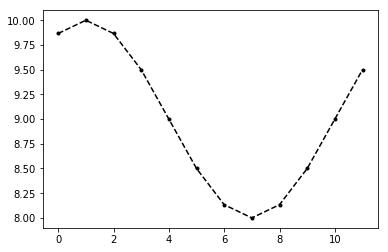

In [57]:
fig, ax = plt.subplots()
ax.plot(sst_n,'k--')
ax.plot(temp_north[:,0], 'k.')

In [15]:
# temp_relax_large_analytical = np.tile(Tstar, (100,200,1)).T
# temp_relax_large_analytical.shape
ds = xr.open_dataset(op.join(ddir, 'BSOSE_rotated_northernboundary-temperature.nc'))
ds

<xarray.Dataset>
Dimensions:      (depth: 52, month: 12)
Coordinates:
  * month        (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
  * depth        (depth) float64 -2.1 -6.7 -12.15 -18.55 -26.25 -35.25 -45.0 ...
Data variables:
    north_Theta  (month, depth) float64 ...

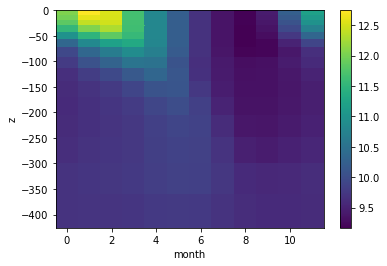

In [24]:
theta = ds.north_Theta
temp_relax = np.zeros((12,len(zaxis)))
z = np.absolute(theta.depth)
for i in range(12):
    f = intp.interp1d(np.absolute(z), theta[i])
    temp_relax[i] = f(np.absolute(zaxis))
temp_relax = xr.DataArray(theta_intp, dims=['month','z'],
                         coords={'month':range(12),'z':zaxis})
temp_relax[:,:15].plot(x='month')

In [25]:
temp_relax.T

<xarray.DataArray (z: 40, month: 12)>
array([[ 12.055796,  12.743659,  12.544059, ...,   9.433958,  10.236496,
         11.198827],
       [ 11.977595,  12.613922,  12.521257, ...,   9.407937,  10.171553,
         11.103379],
       [ 11.836684,  12.41847 ,  12.480182, ...,   9.380547,  10.086563,
         10.970031],
       ..., 
       [  1.666772,   1.670292,   1.673586, ...,   1.670409,   1.671176,
          1.672414],
       [  1.584892,   1.58848 ,   1.59179 , ...,   1.589256,   1.59015 ,
          1.591536],
       [  1.503013,   1.506667,   1.509994, ...,   1.508103,   1.509124,
          1.510658]])
Coordinates:
  * month    (month) int64 0 1 2 3 4 5 6 7 8 9 10 11
  * z        (z) float64 -5.0 -15.0 -25.0 -36.0 -49.0 -64.0 -81.5 -102.0 ...

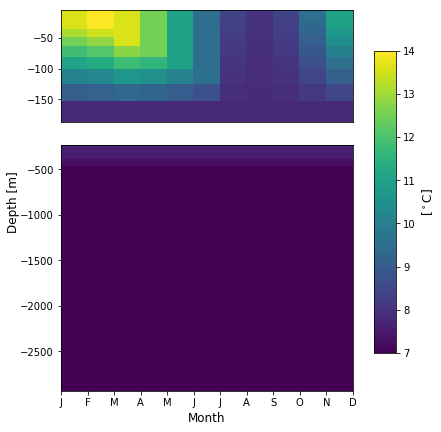

In [48]:
nz = 11
fig = plt.figure(figsize=(6,7))
gs = gridspec.GridSpec(ncols=1, nrows=3)
ax1 = plt.subplot(gs[0,0])
ax2 = plt.subplot(gs[1:,0])
cax = ax1.pcolormesh(range(12), zaxis[:nz], temp_north.T[:nz,:], 
                     vmin=7., vmax=14, rasterized=True)
ax2.pcolormesh(range(12), zaxis[nz:], temp_north.T[nz:,:], 
               vmin=7., vmax=14, rasterized=True)
ax1.set_xticks([])
ax2.set_xticks(range(12))
ax2.set_xticklabels(['J','F','M','A','M','J','J','A','S','O','N','D'])
ax2.set_xlabel('Month', fontsize=12)
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.2, 0.05, 0.6])
cbar = fig.colorbar(cax, cax=cbar_ax)
cbar.set_label(r'[$^\circ$C]',fontsize=12)
fig.text(0, 0.5, 'Depth [m]', 
         va='center', rotation='vertical', fontsize=12)
# plt.savefig('NorthTempRelax_Seasonality.pdf')

In [62]:
print((temp_north[:,:,np.newaxis,np.newaxis]*np.ones((ny,nx))).shape)
(temp_north[:,:,np.newaxis,np.newaxis]*np.ones((ny,nx))).astype(tp).tofile(output_dir 
                                                            + 'rbcs_temp-seasonal-relax_change-of-slope_%03dkm.bin' 
                                                            % res)

(12, 40, 200, 100)


In [6]:
ds = xr.open_dataset(op.join(ddir,'THETA_time-and-zonal-climatology.nc'))
ds

<xarray.Dataset>
Dimensions:               (depth: 40, lat: 200)
Coordinates:
  * depth                 (depth) float64 -5.0 -15.0 -25.0 -36.0 -49.0 -64.0 ...
  * lat                   (lat) float64 -65.0 -64.9 -64.8 -64.7 -64.6 -64.5 ...
Data variables:
    Theta_timeandzonclim  (depth, lat) float64 ...

In [12]:
temp_init = ds.Theta_timeandzonclim.data[:,:,np.newaxis] * np.ones(nx)[np.newaxis,np.newaxis,:]
temp_init[temp_init<1] = 1.
N = temp_init.shape
temp_init += np.random.randn(N[0],N[1],N[2])
# temp_init = temp_relax_large_analytical + np.random.randn(temp_relax_large_analytical.shape[0],
#                                                          temp_relax_large_analytical.shape[1],
#                                                          temp_relax_large_analytical.shape[2])

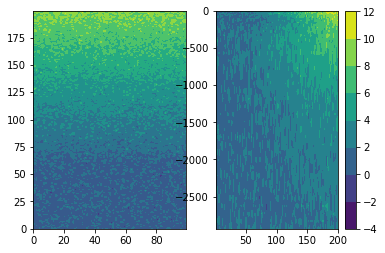

In [13]:
plt.figure()

plt.subplot(121)
plt.contourf(temp_init[0,:,:])

plt.subplot(122)
plt.contourf(range(1,201),zaxis,temp_init[:,:,0])

plt.colorbar()

In [14]:
temp_init.astype(tp).tofile(output_dir + 'THETA_init_warm_%03dkm_BSOSE.bin' % res)

In [26]:
mask = np.zeros((200,100))
mask[-10:] += np.linspace(0.,1.,num=10)[:,np.newaxis] * np.ones((10,100))
rbcs_mask = np.tile(mask,(40,1,1))
rbcs_mask.shape

(40, 200, 100)

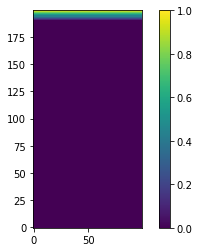

In [30]:
plt.imshow(rbcs_mask[-1], origin='bottom')
plt.colorbar()

In [31]:
rbcs_mask.astype(tp).tofile(output_dir + 'rbcs_temp_relax_mask_%03dkm.bin' % res)

# Nutrient intial conditions

In [5]:
fe = xr.open_dataarray('BSOSE_Fe-transect-climatology.nc')
fe

<xarray.DataArray (depth: 45, lat: 108)>
array([[ 0.000218,  0.000218,  0.000217, ...,  0.000124,  0.000124,  0.000123],
       [ 0.000218,  0.000218,  0.000217, ...,  0.000124,  0.000124,  0.000123],
       [ 0.000219,  0.000218,  0.000217, ...,  0.000124,  0.000124,  0.000123],
       ..., 
       [ 0.000342,  0.000341,  0.000342, ...,  0.00032 ,  0.000321,  0.000322],
       [ 0.000331,  0.000331,  0.000331, ...,  0.000312,  0.000313,  0.000313],
       [ 0.000319,  0.000318,  0.000318, ...,  0.000302,  0.000302,  0.000303]])
Coordinates:
  * depth    (depth) float64 -2.1 -6.7 -12.15 -18.55 -26.25 -35.25 -45.0 ...
  * lat      (lat) float64 -64.97 -64.83 -64.69 -64.54 -64.4 -64.26 -64.11 ...

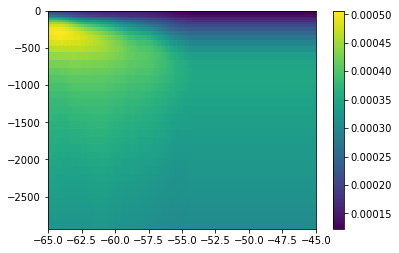

In [9]:
z = np.absolute(fe.depth)
ys = range(len(fe.lat))
f = intp.interp2d(ys, z, fe)
fe_intp = f(range(ny), np.absolute(zaxis))

plt.pcolormesh(np.linspace(-65,-45,num=200),zaxis,fe_intp)
plt.colorbar()

In [8]:
(fe_intp[:,:,np.newaxis]*np.ones(nx)).astype(tp).tofile(output_dir 
                                                        + 'fet_init_latdependency_%03dkm.bin' % res)

In [7]:
ds = xr.open_dataset(op.join(ddir, 'WOA_annualclimatology.nc'))
ds

<xarray.Dataset>
Dimensions:  (depth: 33, lat: 40, lon: 360)
Coordinates:
  * lat      (lat) float32 -79.5 -78.5 -77.5 -76.5 -75.5 -74.5 -73.5 -72.5 ...
  * lon      (lon) float32 0.5 1.5 2.5 3.5 4.5 5.5 6.5 7.5 8.5 9.5 10.5 11.5 ...
  * depth    (depth) float32 0.0 10.0 20.0 30.0 50.0 75.0 100.0 125.0 150.0 ...
    time     datetime64[ns] ...
Data variables:
    t_an     (depth, lat, lon) float64 ...
    s_an     (depth, lat, lon) float64 ...
    p_an     (depth, lat, lon) float64 ...
    n_an     (depth, lat, lon) float64 ...
    i_an     (depth, lat, lon) float64 ...
    t_dd     (depth, lat, lon) float64 ...
    basin    (depth, lat, lon) float64 ...
    pres     (depth, lat) float64 ...
    SA       (depth, lat, lon) float64 ...
    CT       (depth, lat, lon) float64 ...
    sig0     (depth, lat, lon) float64 ...

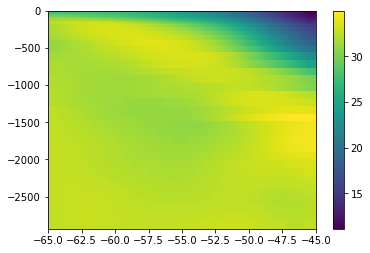

In [13]:
# no3 = xr.open_dataarray('BSOSE_NO3-transect-climatology.nc')
no3 = ds.n_an.sel(lon=slice(100,130),lat=slice(-65,-45),depth=slice(0,3000)).mean('lon')
z = np.absolute(no3.depth)
ys = no3.lat
f = intp.interp2d(ys, z, no3)
no3_intp = f(np.linspace(-65,-45,num=200), np.absolute(zaxis))

plt.pcolormesh(np.linspace(-65,-45,num=200),zaxis,no3_intp)
plt.colorbar()

In [17]:

no3

<xarray.DataArray (depth: 45, lat: 108)>
array([[ 27.598925,  27.58842 ,  27.572538, ...,  16.032441,  15.772613,
         15.508236],
       [ 27.600588,  27.590066,  27.574174, ...,  16.033099,  15.773313,
         15.508956],
       [ 27.609672,  27.598932,  27.582971, ...,  16.035401,  15.776037,
         15.51182 ],
       ..., 
       [ 32.642044,  32.651599,  32.650472, ...,  32.346644,  32.301136,
         32.258563],
       [ 32.657578,  32.664789,  32.664115, ...,  32.001323,  31.939346,
         31.875795],
       [ 32.676714,  32.690285,  32.692034, ...,  31.927572,  31.878   ,
         31.815477]])
Coordinates:
  * depth    (depth) float64 -2.1 -6.7 -12.15 -18.55 -26.25 -35.25 -45.0 ...
  * lat      (lat) float64 -64.97 -64.83 -64.69 -64.54 -64.4 -64.26 -64.11 ...

In [14]:
print((no3_intp[:,:,np.newaxis]*np.ones(nx)).shape)
(no3_intp[:,:,np.newaxis]*np.ones(nx)).astype(tp).tofile(output_dir 
                                                         + 'no3_init_woa_%03dkm.bin' % res)

(40, 200, 100)


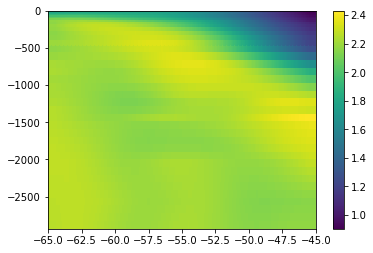

In [15]:
# po4 = xr.open_dataarray('BSOSE_PO4-transect-climatology.nc')
po4 = ds.p_an.sel(lon=slice(100,130),lat=slice(-65,-45),depth=slice(0,3000)).mean('lon')
z = np.absolute(po4.depth)
ys = po4.lat
f = intp.interp2d(ys, z, po4)
po4_intp = f(np.linspace(-65,-45,num=200), np.absolute(zaxis))

plt.pcolormesh(np.linspace(-65,-45,num=200),zaxis,po4_intp)
plt.colorbar()

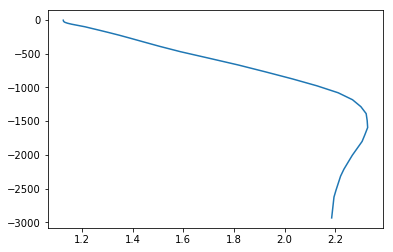

In [22]:
plt.plot(po4_intp[:,-1],zaxis)

In [16]:
print((po4_intp[:,:,np.newaxis]*np.ones(nx)).shape)
(po4_intp[:,:,np.newaxis]*np.ones(nx)).astype(tp).tofile(output_dir 
                                                         + 'po4_init_woa_%03dkm.bin' % res)

(40, 200, 100)


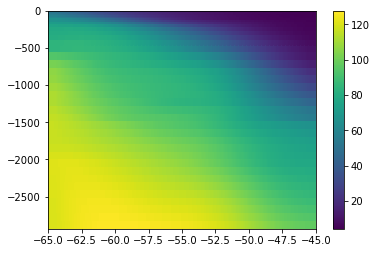

In [17]:
# sio2 = xr.open_dataarray('WOA5deg_SiO2-transect-climatology.nc')
sio2 = ds.i_an.sel(lon=slice(100,130), lat=slice(-65,-45), depth=slice(0,3000)).mean('lon')
z = np.absolute(sio2.depth)
ys = sio2.lat
f = intp.interp2d(ys, z, sio2)
sio2_intp = f(np.linspace(-65,-45,num=200), np.absolute(zaxis))

plt.pcolormesh(np.linspace(-65,-45,num=200), zaxis, sio2_intp)
plt.colorbar()

In [18]:
print((sio2_intp[:,:,np.newaxis]*np.ones(nx)).shape)
(sio2_intp[:,:,np.newaxis]*np.ones(nx)).astype(tp).tofile(output_dir 
                                                         + 'sio2_init_woa_%03dkm.bin' % res)

(40, 200, 100)


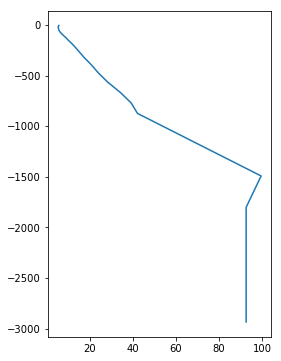

In [20]:
sio2_relax = sio2_intp[:,-1].copy()
sio2_relax[19:26] = np.linspace(sio2_intp[19,-1],sio2_intp.max(),7)
sio2_relax[25:29] = np.linspace(sio2_intp.max(),sio2_intp[15,0],4)
sio2_relax[29:] = sio2_intp[15,0]

plt.figure(figsize=(4,6))
plt.plot(sio2_relax,zaxis)

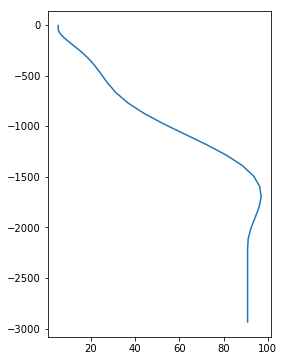

In [35]:
p4 = np.poly1d(np.polyfit(zaxis, sio2_relax, deg=9))
sio2_relax_intp = p4(zaxis)
nmin = np.argmin(sio2_relax_intp)
sio2_relax_intp[:nmin] = sio2_relax_intp.min()
loclmin = np.argmin(sio2_relax_intp[30:35])
sio2_relax_intp[30+loclmin:] = sio2_relax_intp[30:35].min()

plt.figure(figsize=(4,6))
plt.plot(sio2_relax_intp,zaxis)

In [33]:
zaxis

array([   -5. ,   -15. ,   -25. ,   -36. ,   -49. ,   -64. ,   -81.5,
        -102. ,  -126. ,  -154. ,  -187. ,  -226. ,  -272. ,  -327. ,
        -393. ,  -471.5,  -565. ,  -667.5,  -770.5,  -873.5,  -976.5,
       -1079.5, -1182.5, -1285.5, -1388.5, -1491.5, -1594.5, -1697.5,
       -1800.5, -1903.5, -2006.5, -2109.5, -2212.5, -2315.5, -2418.5,
       -2521.5, -2624.5, -2727.5, -2830.5, -2933.5])